In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_fBiPotDDims.recursive_Markovian_PostMeanScore_fBiPot8Dims_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
num_paths = 10240
config = get_config()

In [3]:
def get_drift_files(config):
    ts_type = f"{config.ndims}DDims"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    true_files = []
    local_files = []
    for file in os.listdir(root_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "true" in file:
                true_files.append(root_dir+file)
            elif "local" in file:
                local_files.append(root_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[4][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws

In [4]:
config = get_config()
true_files, local_files, bws = get_drift_files(config=config)
local_files

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_8DDims_DriftTrack_00001bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_8DDims_DriftTrack_0000119bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_8DDims_DriftTrack_0000143bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_8DDims_DriftTrack_000017bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_8DDims_DriftTrack_0000203bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_8DDims

0.007485822230090315 0.0 inf 0


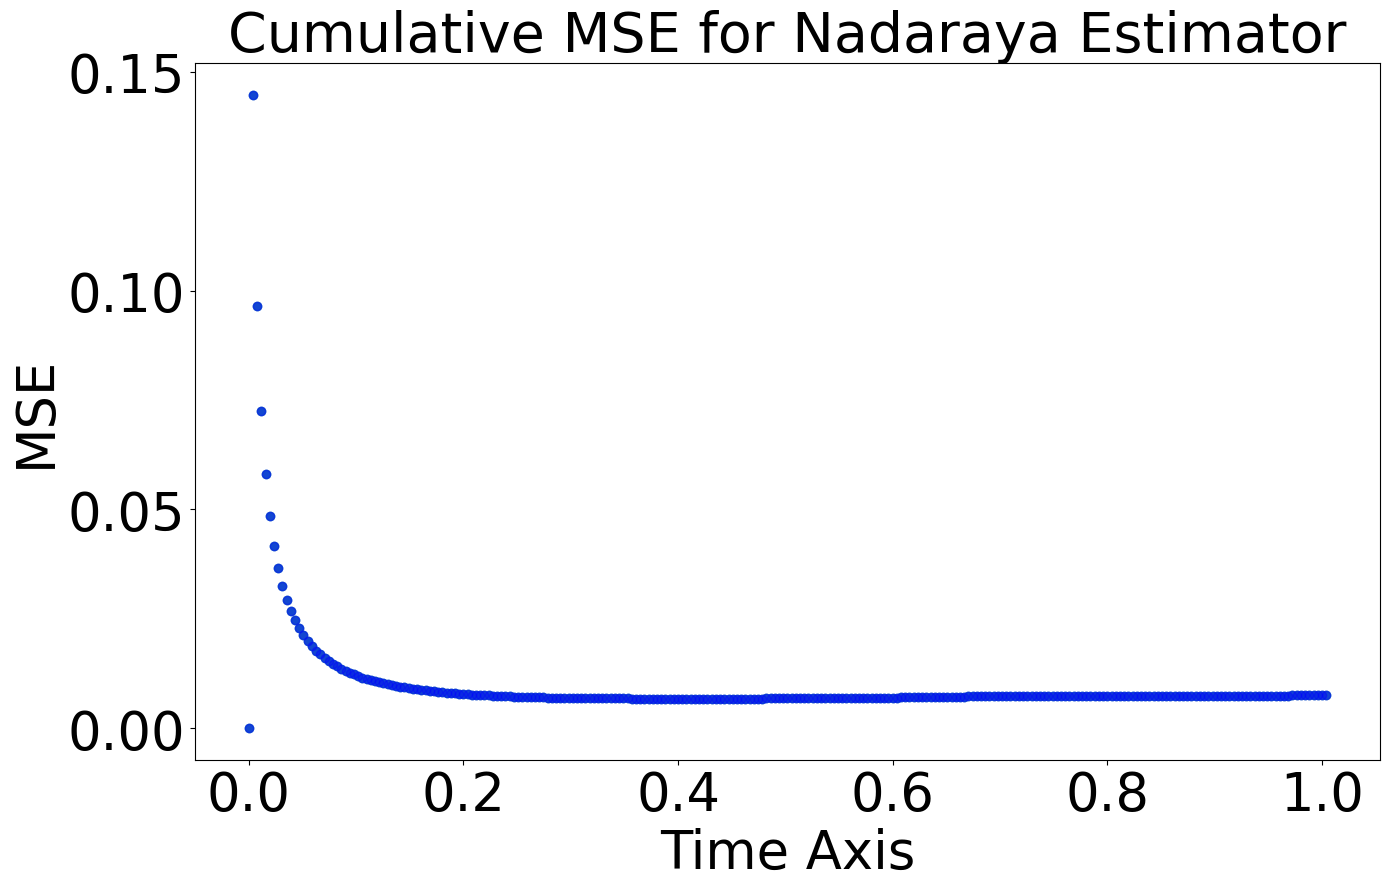

Final time cumulative MSE local-time error 0.007485822230090315 with IQR ((0.007485822230090315, 0.007485822230090315))at bw 1e-05

Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (1e-05, 0, 0.007485822230090315, 0.0, 0.007485822230090315)

0.007040207205226983 0.0 0.007485822230090315 1


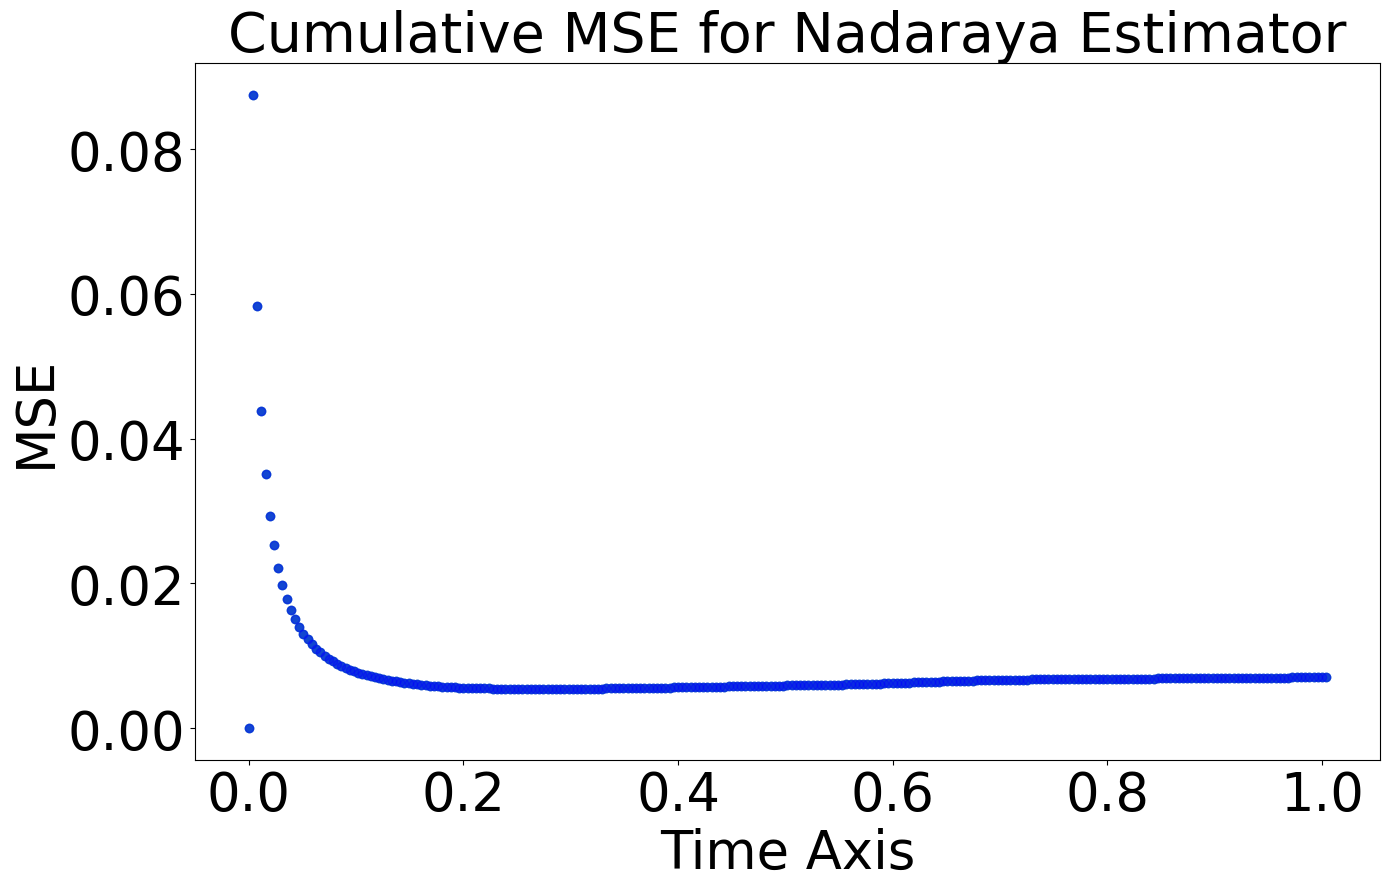

Final time cumulative MSE local-time error 0.007040207205226983 with IQR ((0.0070402072052269836, 0.0070402072052269836))at bw 1.19e-05

Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (1.19e-05, 1, 0.007040207205226983, 0.0, 0.007040207205226983)

0.0066410341396297475 0.0 0.007040207205226983 2


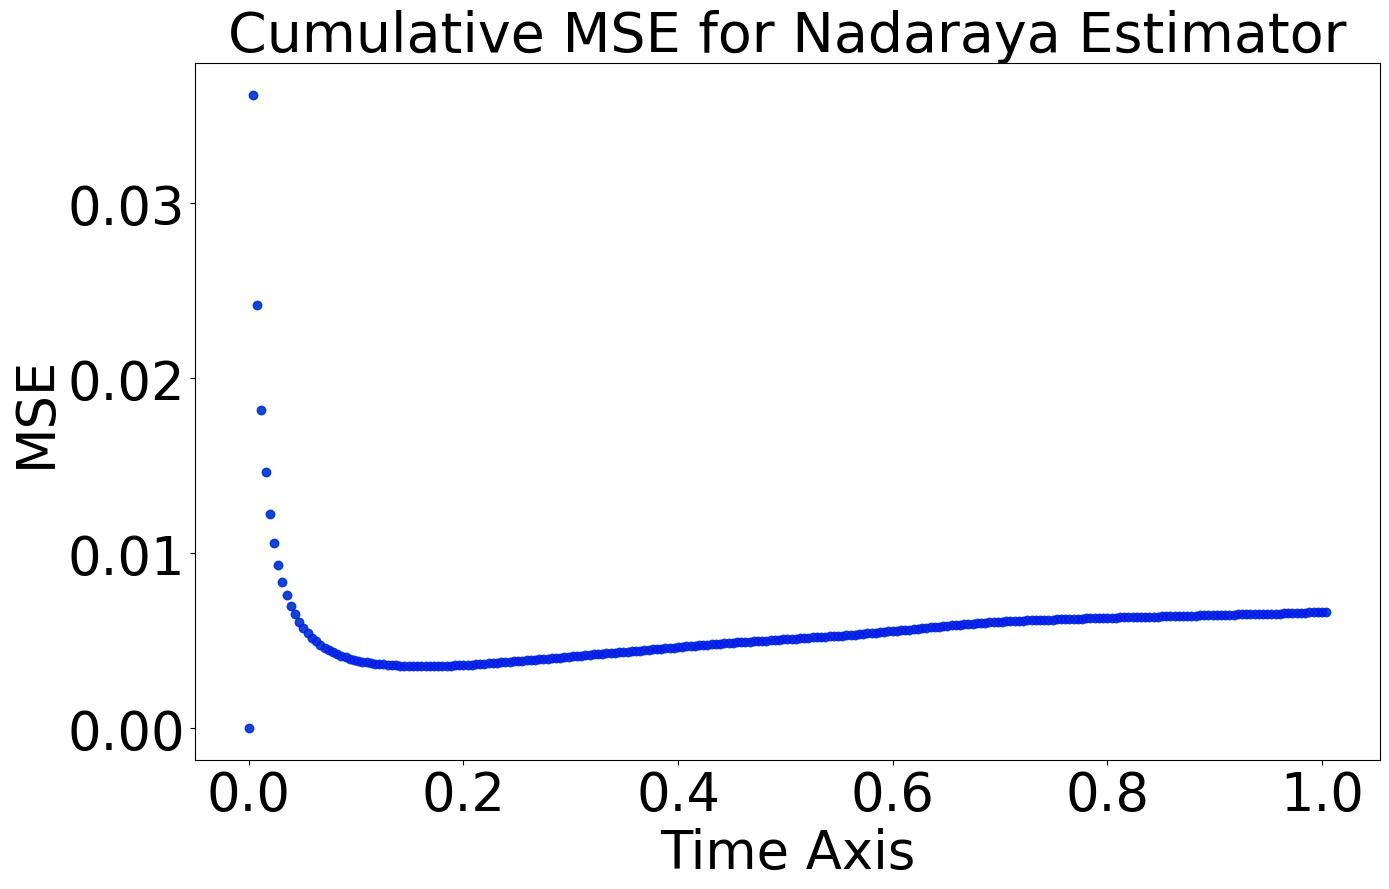

Final time cumulative MSE local-time error 0.0066410341396297475 with IQR ((0.006641034139629747, 0.006641034139629747))at bw 1.43e-05

Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (1.43e-05, 2, 0.0066410341396297475, 0.0, 0.0066410341396297475)

0.006259193663758787 0.0 0.0066410341396297475 3


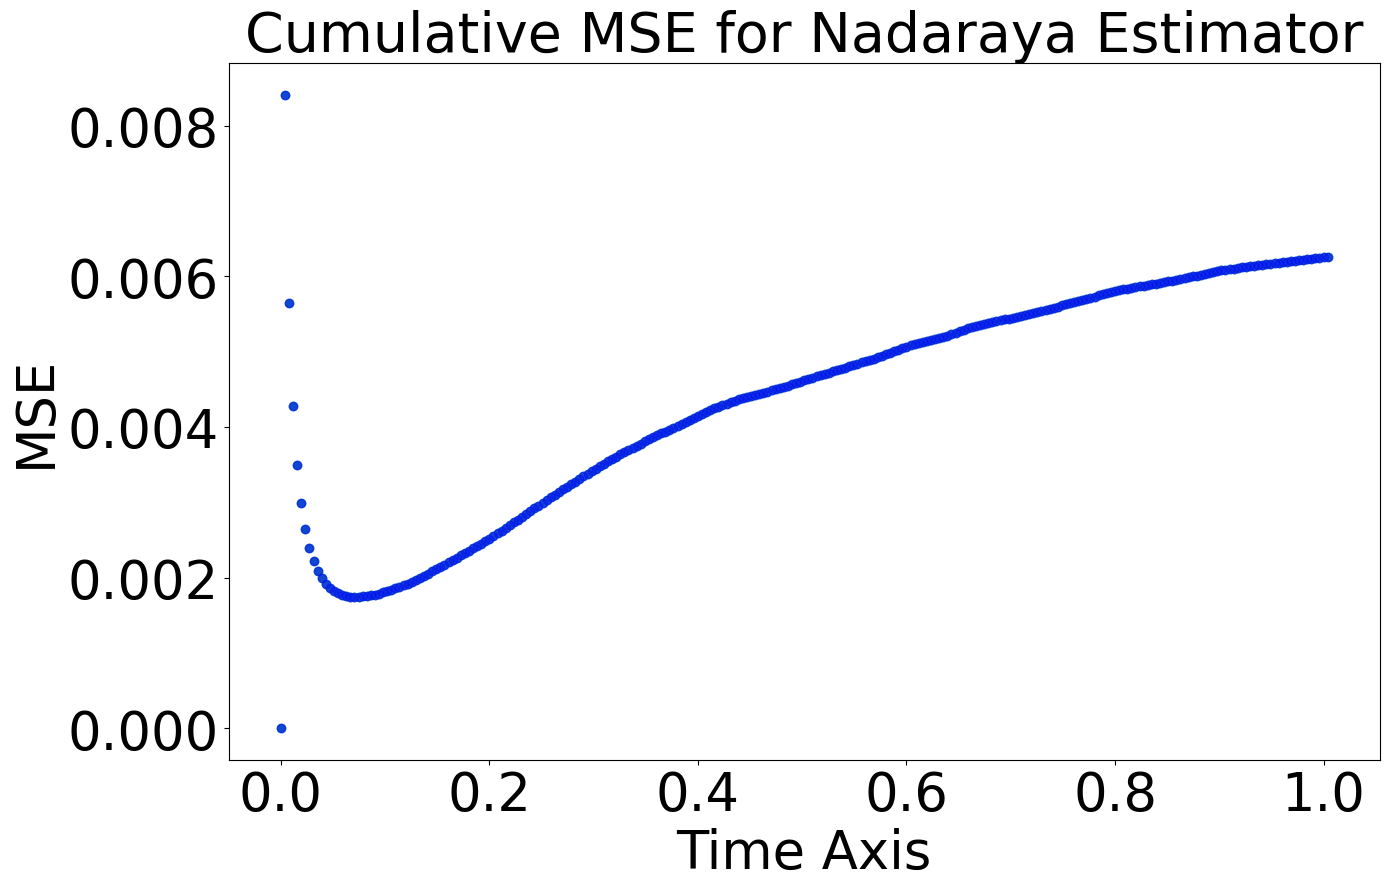

Final time cumulative MSE local-time error 0.006259193663758787 with IQR ((0.006259193663758787, 0.006259193663758787))at bw 1.7e-05

Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (1.7e-05, 3, 0.006259193663758787, 0.0, 0.006259193663758787)

0.006194417511169082 0.0 0.006259193663758787 4


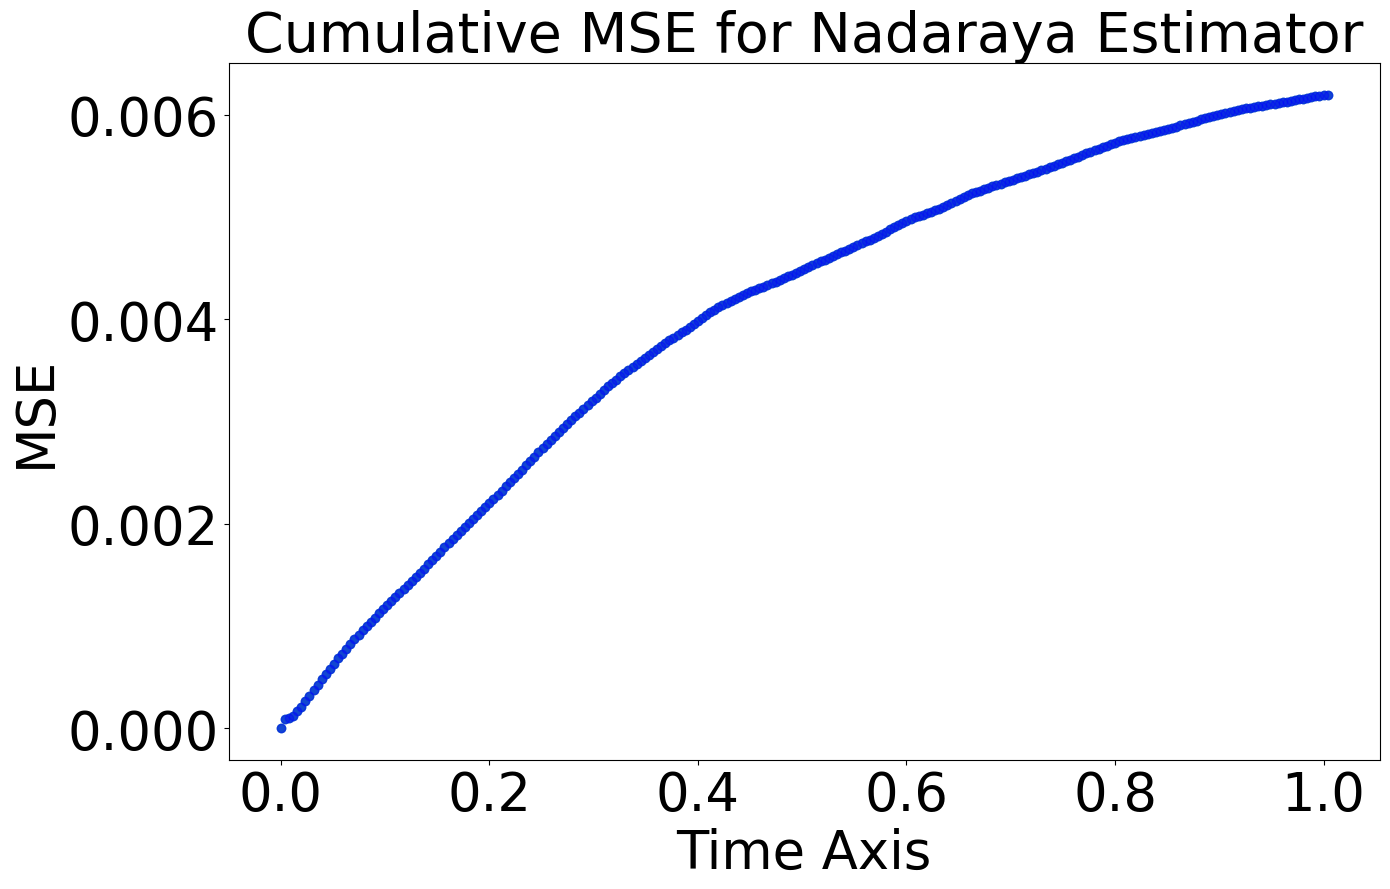

Final time cumulative MSE local-time error 0.006194417511169082 with IQR ((0.0061944175111690826, 0.0061944175111690826))at bw 2.03e-05

Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (2.03e-05, 4, 0.006194417511169082, 0.0, 0.006194417511169082)

0.006215267689928952 0.0 0.006194417511169082 5
Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (2.42e-05, 5, 0.006215267689928952, 0.0, 0.006194417511169082)

0.006250921688651141 0.0 0.006194417511169082 6
Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (2.89e-05, 6, 0.006250921688651141, 0.0, 0.006194417511169082)

0.006236660267130487 0.0 0.006194417511169082 7
Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (3.46e-05, 7, 0.006236660267130487, 0.0, 0.006194417511169082)

0.006193734665075195 0.0 0.006194417511169082 8


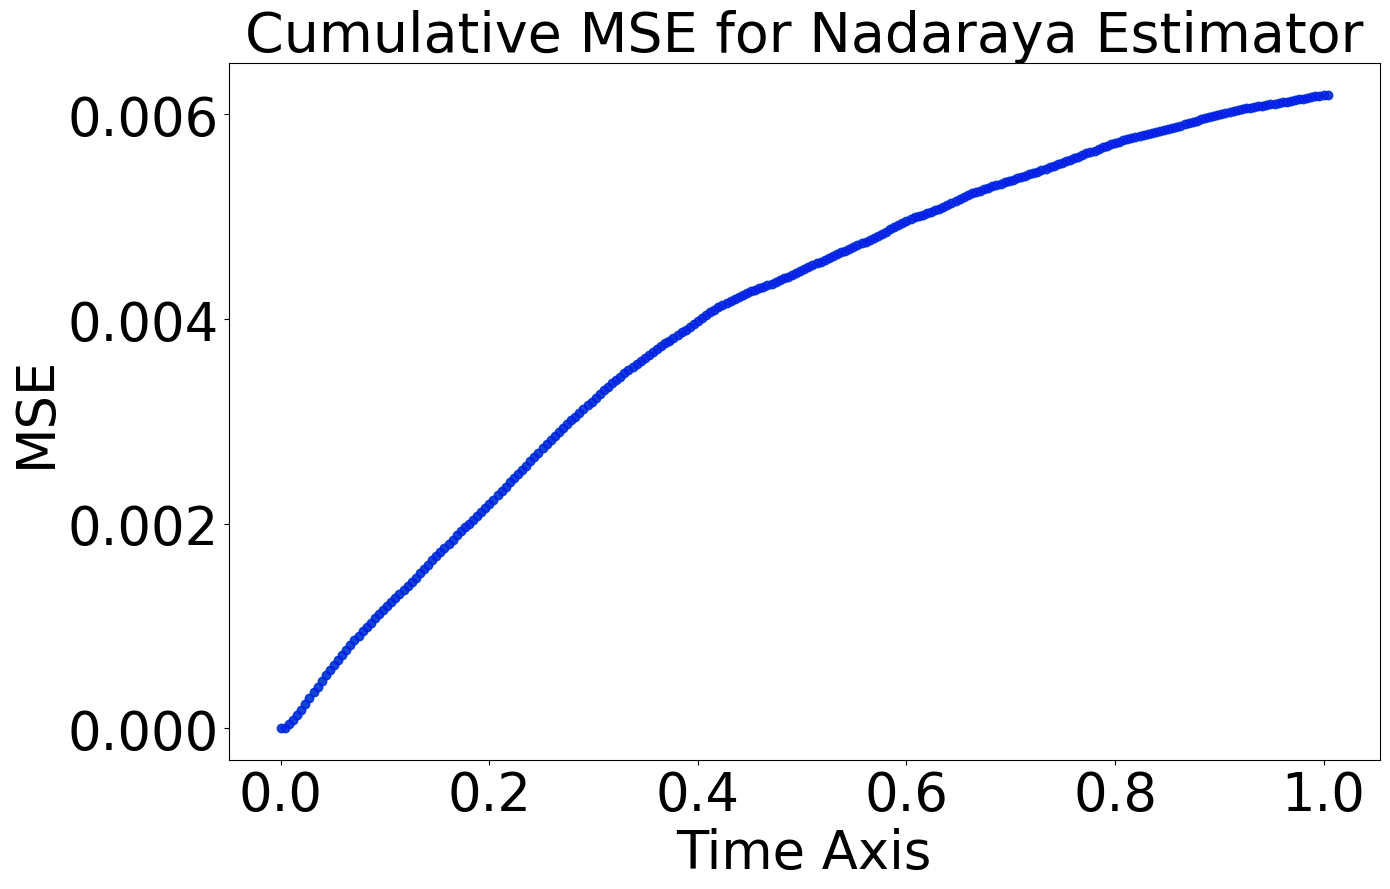

Final time cumulative MSE local-time error 0.006193734665075195 with IQR ((0.006193734665075195, 0.006193734665075195))at bw 4.12e-05

Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (4.12e-05, 8, 0.006193734665075195, 0.0, 0.006193734665075195)

0.0063063194306762094 0.0 0.006193734665075195 9
Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (4.92e-05, 9, 0.0063063194306762094, 0.0, 0.006193734665075195)

0.006645468305422314 0.0 0.006193734665075195 10
Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (5.88e-05, 10, 0.006645468305422314, 0.0, 0.006193734665075195)

0.006928754250635966 0.0 0.006193734665075195 11
Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (7.02e-05, 11, 0.006928754250635966, 0.0, 0.006193734665075195)

0.0069214255751738896 0.0 0.006193734665075195 12
Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (8.38e-05, 12, 0.0069214255751738896, 0.0, 0.006193734665075195)

0.006698955367995087 0.0 0.006193734665075195 13
Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE 

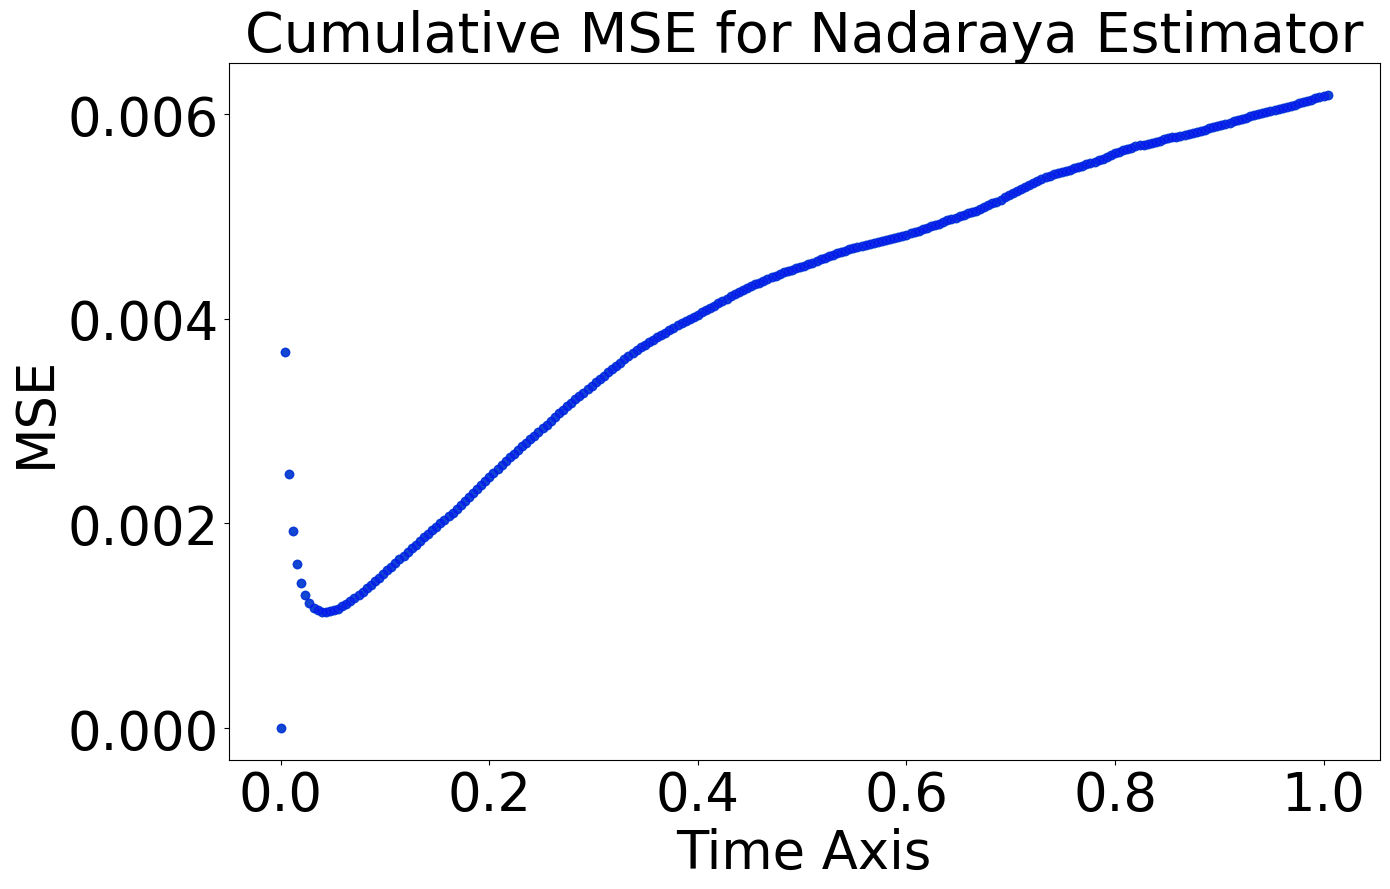

Final time cumulative MSE local-time error 0.006192269780715138 with IQR ((0.006192269780715138, 0.006192269780715138))at bw 0.0001701

Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (0.0001701, 16, 0.006192269780715138, 0.0, 0.006192269780715138)

0.006182811549566845 0.0 0.006192269780715138 17


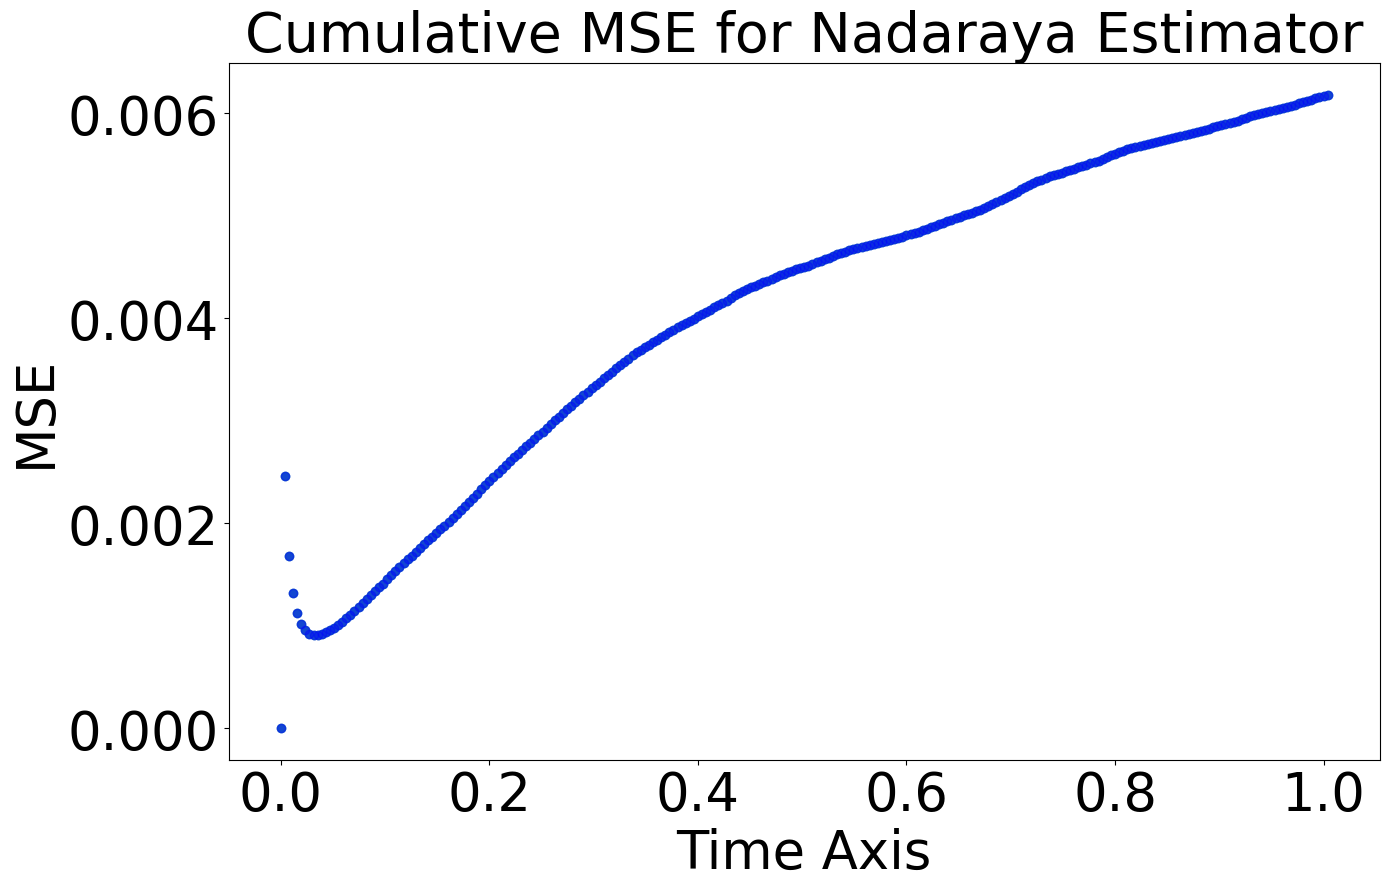

Final time cumulative MSE local-time error 0.006182811549566845 with IQR ((0.006182811549566844, 0.006182811549566844))at bw 0.0002031

Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (0.0002031, 17, 0.006182811549566845, 0.0, 0.006182811549566845)

0.006199017311649401 0.0 0.006182811549566845 18
Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (0.0002424, 18, 0.006199017311649401, 0.0, 0.006182811549566845)

0.006237950720426172 0.0 0.006182811549566845 19
Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (0.0002894, 19, 0.006237950720426172, 0.0, 0.006182811549566845)

0.0062943222456940656 0.0 0.006182811549566845 20
Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (0.0003455, 20, 0.0062943222456940656, 0.0, 0.006182811549566845)

0.007914344567428955 0.0 0.006182811549566845 21
Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE (0.0004125, 21, 0.007914344567428955, 0.0, 0.006182811549566845)

0.012078736363409222 0.0 0.006182811549566845 22
Bandwidth, BWIDX, Error Mean, Error IQR, C

In [8]:
curr_rmse = np.inf
toSave = True
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])/np.sqrt(config.deltaT)
    all_local_states = np.load(file[1])/np.sqrt(config.deltaT)
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean((all_local_errors), axis=0)
        total_local_errors_minq = np.quantile((all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile((all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse, i)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            miny = total_local_errors-total_local_errors_minq
            miny[miny < 0.] = 0.
            maxy = total_local_errors_maxq-total_local_errors
            maxy[maxy < 0.] = 0.
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
            plt.errorbar(time_steps,total_local_errors,yerr=[miny, maxy],xerr=None, fmt='o', color="blue", alpha=0.4)
            ax.set_title(f"Cumulative MSE for Nadaraya Estimator",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/IIDNadaraya_fBiPot_{config.ndims}DDims_DriftTrack_{round(bw, 6)}bw_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw}\n")
        print(f"Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE {bw, np.argwhere(np.array(bws)==bw)[0,0], total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse}\n")

In [6]:
good_idx = 37
bad_idx = 38
good_true = np.load(true_files[good_idx])[0, :, :, :]
good_local = np.load(local_files[good_idx])[0, :,:, :]
bad_true = np.load(true_files[bad_idx])[0, :, :, :]
bad_local = np.load(local_files[bad_idx])[0, :, :,:]
print(bad_local.shape, bad_true.shape)
B, T, D = bad_local.shape

(100, 257, 8) (100, 257, 8)


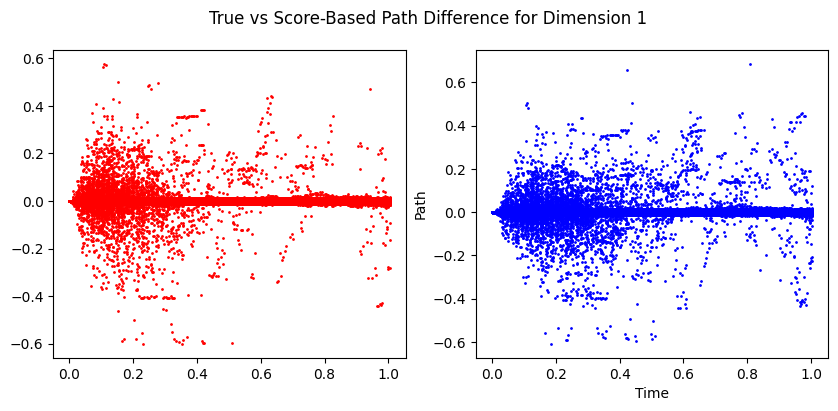

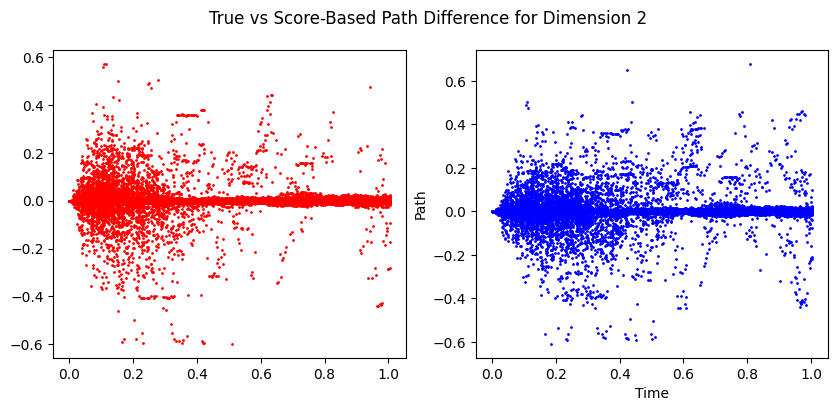

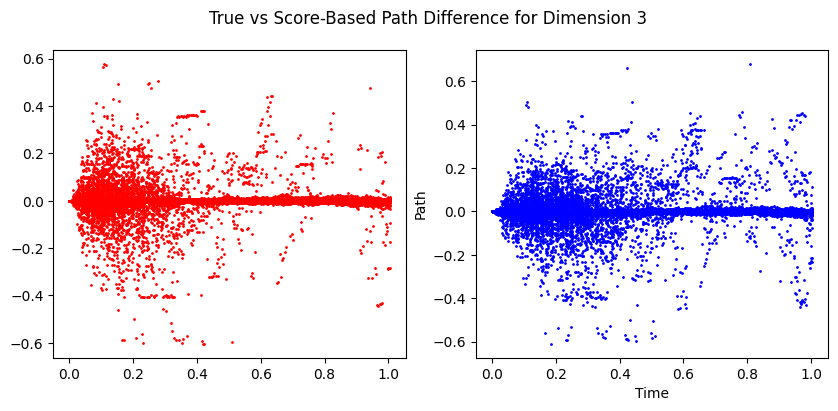

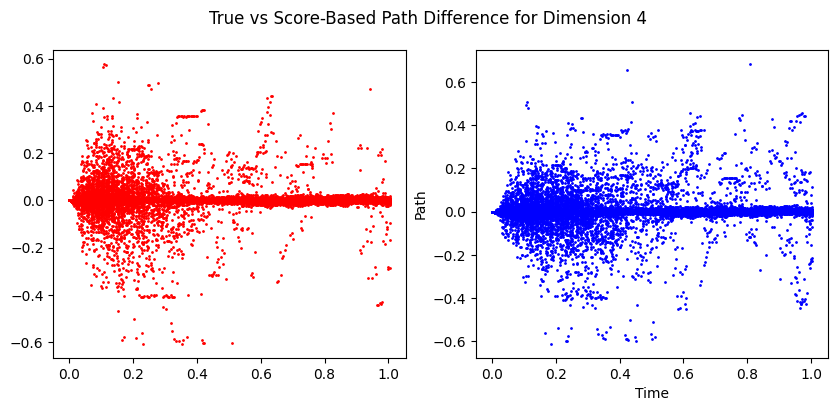

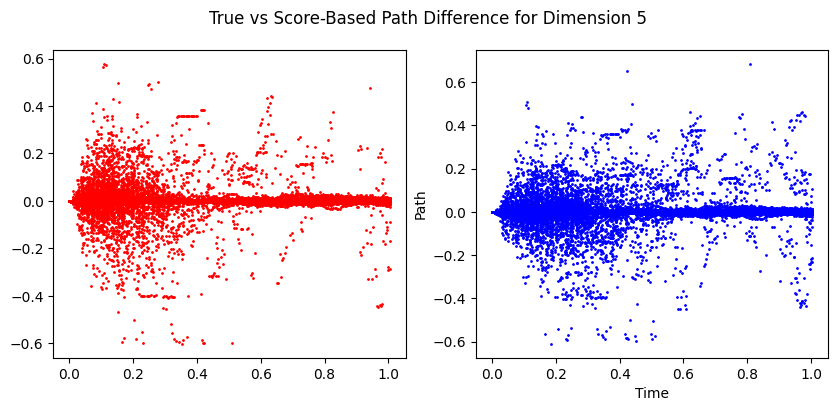

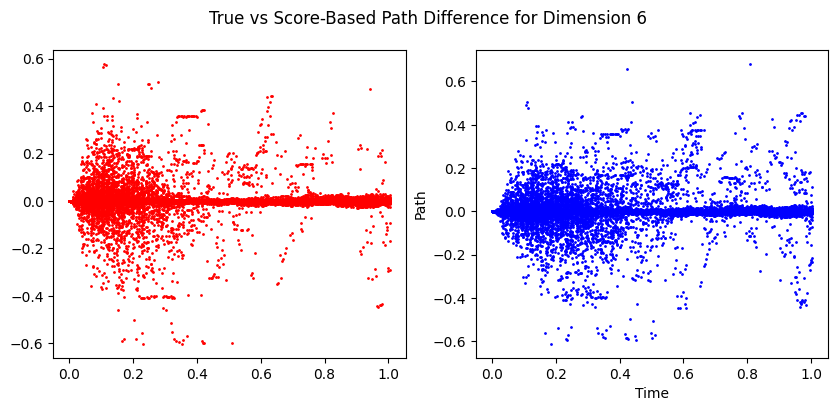

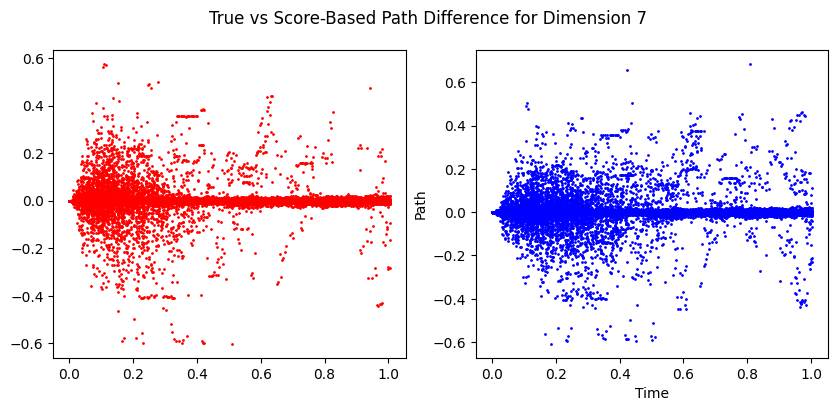

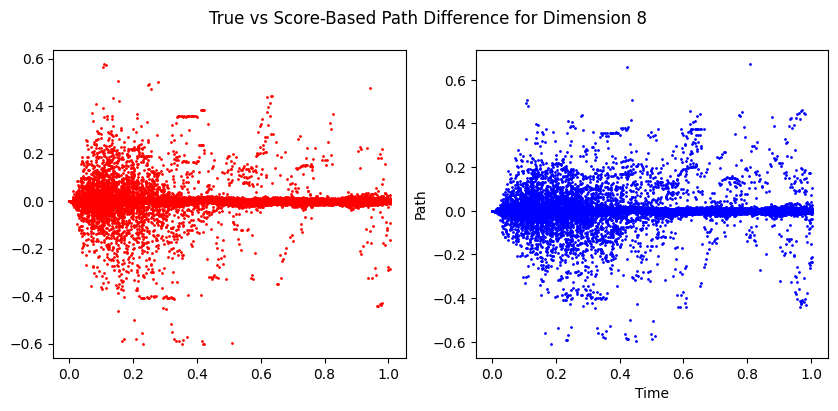

In [7]:
for dim in range(config.ndims):
    dim_idx = dim + 1
    time_ax = np.linspace(config.t0,config.deltaT*T,T)
    # Print different "true sample paths"
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for _ in range(B):
        axes[0].scatter(time_ax, good_true[_, :, dim]-good_local[_, :, dim], color="red", s=1)
        axes[1].scatter(time_ax, bad_true[_, :, dim]-bad_local[_, :, dim], color="blue", s=1)
    plt.suptitle(f"True vs Score-Based Path Difference for Dimension {dim_idx}\n")
    plt.xlabel("Time")
    plt.ylabel("Path")
    plt.show()
    plt.close()